# **Multimodal Neurons**

## Interpreting multimodal information in artificial neural networks

---

This notebook presents our research and experiments focused on the interpretability of multimodal neurons. It documents the methodologies, tests, and analyses we conducted to gain insights into how these neurons process and integrate "multimodal" conceptual information.

This is the structure in which we have organized our code:
```
├── data/                           	# -> Data folder (datasets, images, model checkpoints, etc.)
├── results/                            # -> Results of our experiments
├── lucent/                             # -> Extended lucent framework
├── clip/                               # -> CLIP model
└── neuron_ids.txt                      # -> Neuron/channel/head ids for each learned "concept"
```

## Environment configuration

In [1]:
# For running this project in a hosted runtime

# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# Project directory (change this to the Google Drive directory in which you have saved the project)
# %cd /content/drive/MyDrive/university/roes/multimodal neurons/

# Choose your path (for collaboration) - run in a hosted runtime
# curr_path = "/content/drive/MyDrive/university/roes/multimodal neurons/"

curr_path = "./" # run locally

# "PLAY" IN YOUR OWN COPY

In [3]:
# Environment configuration

# Dependencies and imports
# !pip install torch torchvision torchaudio ftfy regex tqdm deeplake
# !pip install git+https://github.com/openai/CLIP.git # CLIP
# !pip install torch-lucent # don't use this version, we have extended the lucent framework
# !pip install git+https://github.com/microsoft/CLAP.git # CLAP
# !pip install laion-clap # or this implementation of CLAP
# !pip install timm

import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import random
import os
import plotly.express as px
import plotly.graph_objects as go
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import re
import itertools
from pprint import pprint
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms, datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy
from scipy.spatial.distance import cdist
from skimage.transform import pyramid_reduce

import clip
from clip.simple_tokenizer import SimpleTokenizer as Tokenizer
from msclap import CLAP
import laion_clap

import deeplake
import fiftyone as fo
import fiftyone.zoo as foz

from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence
from lucent.modelzoo.util import get_model_layers
from lucent.misc.io import show
from lucent.optvis.param.color import to_valid_rgb

from transformers import AutoProcessor, AutoModel, BertTokenizer, GPT2LMHeadModel, AutoTokenizer, BertLMHeadModel, BertForMaskedLM
from sentence_transformers import SentenceTransformer

import timm # pytorch image models
from timm.models.layers import PatchEmbed
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor # access intermediate transformations of inputs

# import mmf # multimodal models
# from mmf.common.registry import registry
# from mmf.common.sample import Sample, SampleList
# from mmf.utils.configuration import load_yaml
# from mmf.utils.env import setup_imports
# from mmf.utils.build import build_model, build_processors
# from mmf.models.vilbert import ViLBERT

import nltk
nltk.download('words')
from nltk.corpus import words

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data
data_path = curr_path + "data/"

[nltk_data] Downloading package words to /home/angelos/nltk_data...
[nltk_data]   Package words is already up-to-date!


## CLIP model

Initially, we will reproduce most of the techniques and experiment results showcased in the [OpenAI Multimodal Neurons](https://distill.pub/2021/multimodal-neurons/#conditional-probability) article, particularly for the **CLIP RN50x4** model.

In [4]:
# CLIP available models

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
# Load the CLIP model

# model, preprocess = clip.load("RN50x4", device=device) # RN
model, preprocess = clip.load("ViT-B/16", device=device) # ViT
# model, preprocess = AutoModel.from_pretrained("facebook/metaclip-b32-400m"), AutoProcessor.from_pretrained("facebook/metaclip-b32-400m") # MetaCLIP

model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

## Zero-shot classification

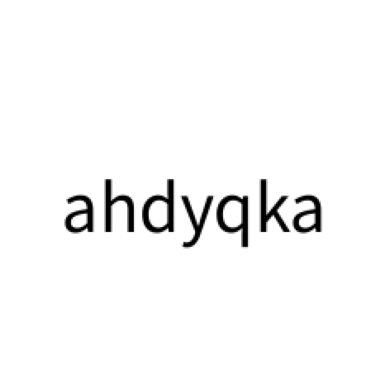

london: 0.032867431640625
car: 0.042388916015625
ahdyqka: 0.1826171875
akalo: 0.09967041015625
londno: 0.0667724609375
ください: 0.032806396484375
医者: 0.040435791015625
english: 0.04974365234375
japanese: 0.0679931640625
africa: 0.054412841796875
black: 0.03704833984375
idiot: 0.031494140625
japan: 0.04058837890625
うし: 0.041961669921875
すし: 0.046722412109375
sushi: 0.0272064208984375
kudasai: 0.06549072265625
こんにちは: 0.039642333984375


In [20]:
# Example usage (zero-shot classification)

# Show image
text = "ahdyqka" # word image, test visual comprehension
image = text_to_image(text, font_size=40, image_size=(224, 224), vertical_offset=5, font_path=data_path + "NotoSansJP-Regular.ttf")
# image = Image.open(data_path + "dog_cat.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess image
image = preprocess(image).unsqueeze(0).to(device)
# image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

# Tokenize text
# texts = ["This is a dog", "This is a cat", "This is a dog and a cat"]
texts = ["konichiwa", "london", "car", "ahdyqka", "akalo", "londno","ください", "医者", "english", "japanese", "africa", "black", "idiot", "japan", "うし", "すし", "sushi", "kudasai", "こんにちは"]
# exclude = ["ください", "医者", "うし", "すし", "japanese"]
# exclude = []
texts = [word for word in texts if word not in exclude]
text_tokens = clip.tokenize(texts).to(device)

# Calculate similarity
with torch.no_grad():
  # image_features = model.encode_image(image) # RN
  image_features, _, _ = model.encode_image(image) # ViT
  text_features = model.encode_text(text_tokens)

  image_features = image_features / image_features.norm(dim=1, keepdim=True) # ViT
  text_features = text_features / text_features.norm(dim=1, keepdim=True)
  logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).exp()
  logits_per_image = logit_scale * image_features @ text_features.t()
  logits_per_text = logits_per_image.t()

  # logits_per_image, logits_per_text = model(image, text_tokens) # RN
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for i, text in enumerate(texts):
  print(f"{text}: {probs[0][i]}")

## Feature visualization

In [72]:
# Vision side of the CLIP model

vision_side = model.visual
# vision_side = model.vision_model # MetaCLIP -> transformer-based architecture

In [73]:
# Vision side model layers

layers = get_model_layers(vision_side)
print(layers)

['conv1', 'bn1', 'relu1', 'conv2', 'bn2', 'relu2', 'conv3', 'bn3', 'relu3', 'avgpool', 'layer1', 'layer1_0', 'layer1_0_conv1', 'layer1_0_bn1', 'layer1_0_relu1', 'layer1_0_conv2', 'layer1_0_bn2', 'layer1_0_relu2', 'layer1_0_avgpool', 'layer1_0_conv3', 'layer1_0_bn3', 'layer1_0_relu3', 'layer1_0_downsample', 'layer1_0_downsample_-1', 'layer1_0_downsample_0', 'layer1_0_downsample_1', 'layer1_1', 'layer1_1_conv1', 'layer1_1_bn1', 'layer1_1_relu1', 'layer1_1_conv2', 'layer1_1_bn2', 'layer1_1_relu2', 'layer1_1_avgpool', 'layer1_1_conv3', 'layer1_1_bn3', 'layer1_1_relu3', 'layer1_2', 'layer1_2_conv1', 'layer1_2_bn1', 'layer1_2_relu1', 'layer1_2_conv2', 'layer1_2_bn2', 'layer1_2_relu2', 'layer1_2_avgpool', 'layer1_2_conv3', 'layer1_2_bn3', 'layer1_2_relu3', 'layer1_3', 'layer1_3_conv1', 'layer1_3_bn1', 'layer1_3_relu1', 'layer1_3_conv2', 'layer1_3_bn2', 'layer1_3_relu2', 'layer1_3_avgpool', 'layer1_3_conv3', 'layer1_3_bn3', 'layer1_3_relu3', 'layer2', 'layer2_0', 'layer2_0_conv1', 'layer2_0_bn

100%|███████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.95it/s]



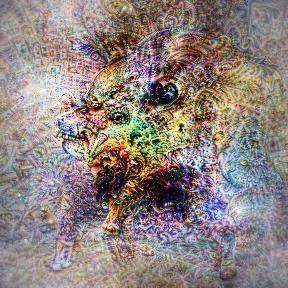

In [ ]:
# Define the layer and neuron/channel for feature visualization (activation maximization)

# Notes:
# * Channel optimization objective results in a repeating pattern
# * Neuron optimization objective shows spatial preferences

layer_name = "layer4_5_conv3"
neuron_channel_index = 1739 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))
# _ = render.render_vis(vision_side, "layer3_3_conv3:168", show_inline=True) # or this

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 18.23it/s]



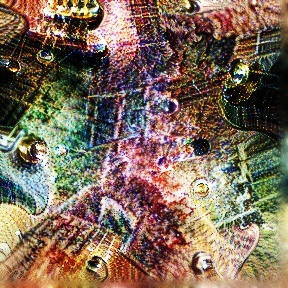

In [ ]:
# Here we try different tranformations for regularization

layer_name = "layer4_5_relu3"
neuron_channel_index = 1093 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_channel_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index)

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

100%|███████████████████████████████████████████████████| 512/512 [00:21<00:00, 23.32it/s]



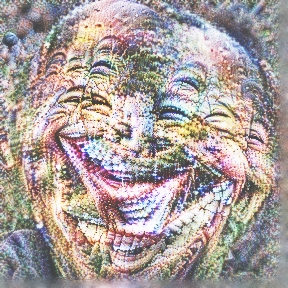

In [ ]:
# Define the layer and neuron/channel for feature visualization - let's try other objectives (e.g. adding a blur alpha term)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_channel_obj_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1e3 * objectives.blur_alpha_each_step() # we experiment with this

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Deep dream

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.37it/s]



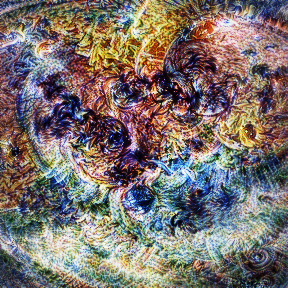

In [ ]:
# Define the layer for feature visualization - deepdream

layer_name = "layer4_5_conv3"
image_path = f"results/feature_vis_deepdream_{layer_name}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.deepdream(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Neuron interactions

100%|███████████████████████████████████████████████████| 512/512 [00:32<00:00, 15.68it/s]



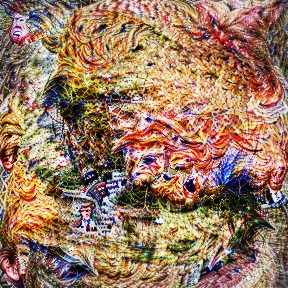
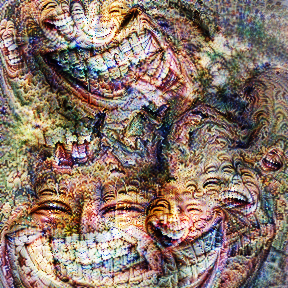
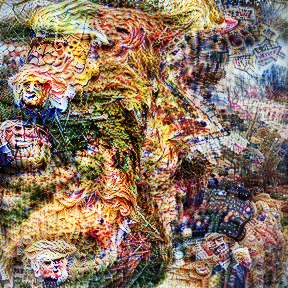

In [ ]:
# Neuron interactions (combined neurons, interpolation, etc.)

# * Negative visualizations
# layer_name = "layer4_5_bn3"
# neuron_channel_index = 1257 # 1739 is evil, 1512 is happy, 1257 is west africa
# image_path = f"results/feature_vis_negative_{layer_name}_{neuron_channel_index}.png"

# batch_param_f = lambda: param.image(288, batch=2, decorrelate=True)
# obj = objectives.channel(layer_name, neuron_channel_index, batch=1) - objectives.channel(layer_name, neuron_channel_index, batch=0)

# _ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

# * Interpolation
# def interpolate_param_f():
#   params, image_f = param.fft_image((6, 3, 128, 128))
#   shared = [
#       param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
#       param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
#       param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
#       param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
#       param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
#       param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
#   ]
#   images = []
#   for (p, i) in shared:
#       params += p
#       images.append(i)
#   return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# # tforms = [ # we can experiment with these transformations
# #     transform.pad(12, mode="constant", constant_value=.5),
# #     transform.jitter(8),
# #     transform.random_scale([.75]),
# # ]

# tforms = [
#         transform.pad(2, mode='constant', constant_value=.5),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
#         transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
#         transform.jitter(2)
# ]

# # obj = objectives.channel_interpolate("layer4_5_bn3", 1512, "layer4_5_conv3", 1739) # from "happy" to "evil"
# obj = objectives.channel_interpolate("layer4_5_bn3", 1512, "layer4_5_conv3", 1739) + 0.15 *  objectives.alignment('layer4_3', decay_ratio=5) # from "happy" to "evil"

# image_path = f"results/feature_vis_interpolation_happy_evil.png"
# sequence = render.render_vis(vision_side, obj, interpolate_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

# * Combined neurons (we should think of *interesting* combinations)
neuron1 = ("layer4_5_bn3", 89) # e.g., trump neuron
neuron2 = ("layer4_5_bn3", 1512) # e.g., happy neuron -> here we anticipate a happy trump result
image_path = f"results/feature_vis_combined_neurons_{neuron1[1]}_{neuron2[1]}.png"

batch_param_f = lambda: param.image(288, batch=3, decorrelate=True)
obj = lambda neuron1, neuron2: objectives.channel(*neuron1, batch=0) + \
  objectives.channel(*neuron2, batch=1) + \
  objectives.channel(*neuron1, batch=2) + \
  objectives.channel(*neuron2, batch=2)

_ = render.render_vis(vision_side, obj(neuron1, neuron2), batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Feature inversion - caricature

100%|███████████████████████████████████████████████████| 320/320 [00:15<00:00, 20.39it/s]



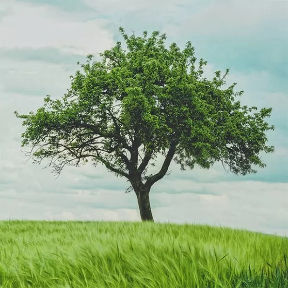
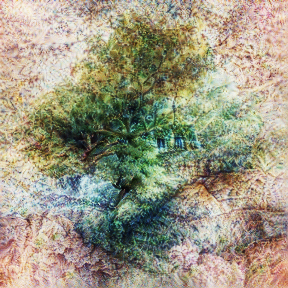

In [ ]:
# Caricature -> this needs caution for optimization instabilities

layer_name = "layer4_5_conv3"

target_image = Image.open(data_path + "field.jpg")  # target image
transform_to_tensor = transforms.ToTensor()
target_image = transform_to_tensor(target_image).unsqueeze(0)
upsample = torch.nn.Upsample(size=(288, 288), mode='bilinear', align_corners=False)
target_image = upsample(target_image).squeeze(0).to(device)

image_path = f"results/feature_vis_caricature_{layer_name}_field.png"

obj = objectives.Objective.sum([
    1.0 * objectives.dot_compare(layer_name, cossim_pow=1.0),
    # -0.25 * objectives.blur_input_each_step()
    -0.1 * objectives.total_variation()
  ])

params, image_f = param.image(288)
def stacked_param_f():
  return params, lambda: torch.stack([target_image, image_f()[0]])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

# tforms = [
#         transform.pad(2, mode='constant', constant_value=.5),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
#         transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
#         transform.jitter(2)
# ]

# tforms = [
#     transform.pad(8, mode='constant', constant_value=.5),
#     transform.jitter(8),
#     transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
#     transform.random_rotate(list(range(-5, 5)) + [0]*5),
#     transform.jitter(2),
# ]

_ = render.render_vis(vision_side, obj, stacked_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(320,))

## Dataset samples

Here we find the top-k images in a dataset that maximally activate a given neuron/channel. We will experiment with the **PACS**, **ImageNet** and **COCO** datasets. Furthermore, we will find the top-k English words which most activated the neuron when rastered as images.

### **PACS dataset**

In [ ]:
# Load the PACS dataset

pacs_ds = deeplake.load("hub://activeloop/pacs-train")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



|

hub://activeloop/pacs-train loaded successfully.



In [ ]:
# Dataloader

tform = transforms.Compose([ # transforms
    transforms.ToPILImage(),
    preprocess # CLIP preprocessing
])

batch_size = 4 # batch size

dataloader = pacs_ds.pytorch(batch_size=batch_size, num_workers=0, # dataloader
    transform = {'images': tform, 'labels': None}, shuffle=True)

### **ImageNet dataset**

In [ ]:
# Load the ImageNet dataset

# Transformations
tform = transforms.Compose([
    # transforms.ToPILImage(),
    preprocess, # CLIP preprocessing
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# tform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

batch_size = 4 # batch size

imagenet_data_path = data_path + 'tiny-imagenet-200'
train_imagenet_dataset = datasets.ImageFolder(imagenet_data_path + '/train', transform=tform)
train_imagenet_loader = DataLoader(train_imagenet_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = train_imagenet_loader

### **COCO dataset**

In [ ]:
# Load the COCO dataset

print(foz.list_zoo_datasets()) # list available zoo datasets

coco_dataset = foz.load_zoo_dataset("coco-2017", split="validation")

class COCODataset(Dataset):
    def __init__(self, fiftyone_dataset, transform=None):
        self.samples = []
        self.transform = transform

        for sample in fiftyone_dataset:
          self.samples.append(sample.filepath)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filepath = self.samples[idx]
        image = Image.open(filepath)

        if self.transform:
          image = self.transform(image)

        return image

# Transformations
tform = transforms.Compose([
    preprocess, # CLIP preprocessing
    # transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 4 # batch size

coco_pytorch_dataset = COCODataset(coco_dataset, transform=tform)
coco_loader = DataLoader(coco_pytorch_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = coco_loader

['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'fiw', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'kitti-multiview', 'lfw', 'mnist', 'open-images-v6', 'open-images-v7', 'quickstart', 'quickstart-geo', 'quickstart-groups', 'quickstart-video', 'sama-coco', 'ucf101', 'voc-2007', 'voc-2012']
Found annotations at '/home/angelos/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### **Words rastered as images**

In [6]:
# Rastering words into images

def text_to_image(text, image_path=None, font_size=40, image_size=(288, 288), vertical_offset=0, font_path=None):
  if font_path is not None:
    font = ImageFont.truetype(font_path, font_size)
  else:
    try:
      font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
      print("Arial font not found, using default font.")
      font = ImageFont.load_default()

  image = Image.new("RGB", image_size, "white")
  draw = ImageDraw.Draw(image)
  _, _, text_width, text_height = draw.textbbox((0, 0), text=text, font=font)
  text_top = ((image_size[1] - text_height) // 2) + vertical_offset
  text_left = (image_size[0] - text_width) // 2
  draw.text((text_left, text_top), text, fill="black", font=font)
  if image_path is not None:
    image.save(image_path)
  return image


def text_to_tensor(text, font_size=40, image_size=(288, 288), vertical_offset=0, font_path=None):
  image = text_to_image(text, font_size=font_size, image_size=image_size, vertical_offset=vertical_offset, font_path=font_path)
  return preprocess(image).unsqueeze(0).to(device)


class RasterizedTextDataset(Dataset):
  def __init__(self, vocabulary, font_size=40, image_size=(288, 288), transform=None):
    self.vocabulary = vocabulary
    self.font_size=font_size
    self.image_size = image_size
    self.transform = transform

  def __len__(self):
    return len(self.vocabulary)

  def __getitem__(self, idx):
    text = self.vocabulary[idx]
    image = text_to_tensor(text, font_size=self.font_size, image_size=self.image_size).squeeze(0)
    if self.transform:
      image = self.transform(image)
    return image

batch_size = 1 # batch size

# vocabulary = ... (TODO: use a large diverse vocabulary with phrases)
# or "manually":
vocabulary = ["happy", "sad", "youpii", "anxious", "funny", "lying", "trump", "river", "lake", "wow", "this is fantastic", "wall", "usa" "trupm", "donald duck"] # vocabulary
rasterized_text_dataset = RasterizedTextDataset(vocabulary=vocabulary, font_size=40, image_size=(288, 288))
rasterized_text_loader = DataLoader(rasterized_text_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = rasterized_text_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


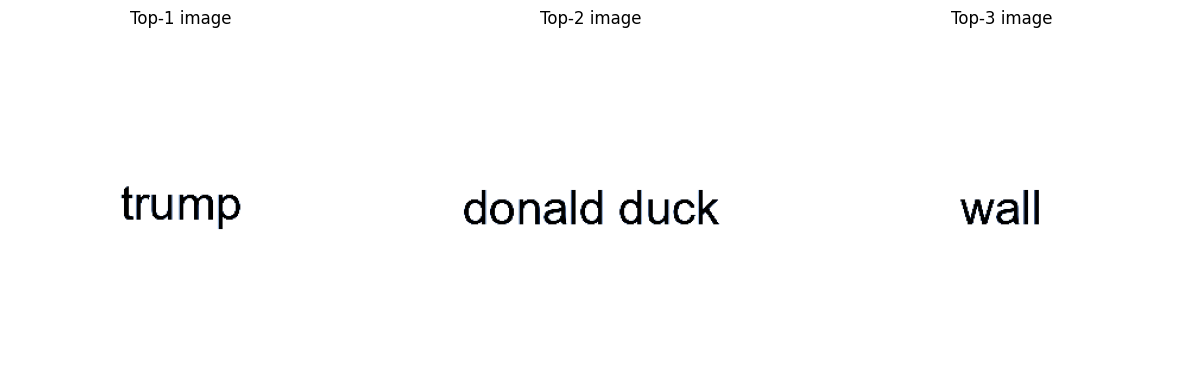

In [ ]:
# Top-k images/stimuli in the selected dataset that most activate a given neuron (channel)

activations = []
def get_activation(name):
  def hook(model, input, output):
    activations.append(output.detach())
  return hook

# Define the layer and channel
layer_number = getattr(vision_side, 'layer4')
block = layer_number[5]
layer = getattr(block, 'bn3')
neuron_index = 89 # 1512 (bn3) is "happy", 1739 (conv3) is "evil"

hook = layer.register_forward_hook(get_activation('layer_4_5_bn3')) # hook

# Process the images and record the activations
# max_batches = 1000 # number of batches
max_batches = len(vocabulary)

batch_count = 0
saved_images = []
with torch.no_grad():
  for inputs in dataloader:
    if batch_count >= max_batches:
      break

    # images = inputs['images'] # PACS
    # images = inputs[0] # ImageNet
    images = inputs # COCO, words rastered as images

    saved_images.extend(images.cpu().numpy())

    images = images.to(dtype=torch.float32, device=device)
    _ = vision_side(images)

    batch_count += 1

hook.remove()
activations = torch.cat(activations, dim=0)

# Top-k images in the dataset
k = 3
neuron_activations = activations[:, neuron_index].mean(dim=(1, 2))
top_image_indices = torch.argsort(neuron_activations, descending=True)[:k]
topk_images = [saved_images[i] for i in top_image_indices]
topk_activations = [activations[i, :].mean(dim=(1, 2)) for i in top_image_indices] # store the activations (averaging over the spatial dimensions of each channel)

# Show the top-k images
fig, axes = plt.subplots(1, len(topk_images), figsize=(15, 5))
if not isinstance(axes, (np.ndarray, list)):
  axes = [axes]

for i, image in enumerate(topk_images):
  ax = axes[i]
  ax.imshow(image.transpose(1, 2, 0))
  # ax.imshow(image)
  ax.set_title(f"Top-{i+1} image")
  ax.axis('off')

plt.savefig(f"results/dataset_samples_rasterized_words_trump.png") # save the fig

plt.show()

## Faceted feature visualization

### **Multifaceted feature visualization**

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.50it/s]



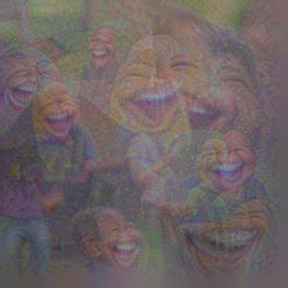

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 17.74it/s]



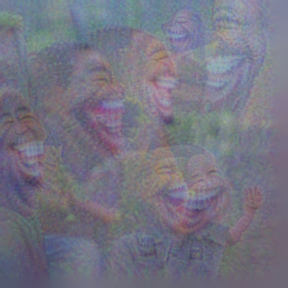

100%|███████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.64it/s]



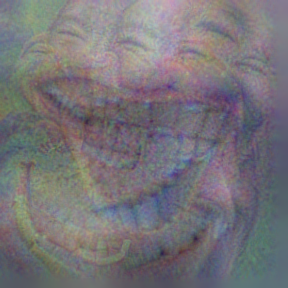

100%|███████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.76it/s]



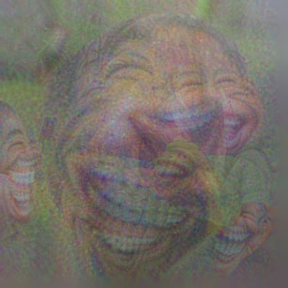

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 18.19it/s]



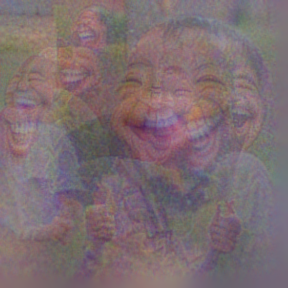

In [ ]:
# MFV (see https://arxiv.org/pdf/1602.03616.pdf) - we will also implement the center-biased regularization (if time permits)

# The set of images U are the training set images that maximally activate a neuron/channel (top-k images found earlier)
facets = 5 # number of facets

# Extract high-level features for each image
# features = [activation.cpu().numpy() for activation in topk_activations] # we did it earlier (topk_activations), via averaging over the spatial dimensions of each channel (dim)
# , or we can try something different like:
with torch.no_grad():
  features = [model.encode_image(torch.from_numpy(image).unsqueeze(0).to(device)).squeeze(0).cpu().numpy() for image in topk_images] # final image embeddings

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(np.vstack(features))

# Run t-SNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_pca)

# Clustering
kmeans = KMeans(n_clusters=facets)
clusters = kmeans.fit_predict(features_tsne)
distances = cdist(features_tsne, kmeans.cluster_centers_, metric='euclidean') # distances to centroids

# Mean images
m = 15 # average the top-m images per cluster
mean_images_initialization = []
for i in range(facets):
  cluster_indices = np.where(clusters == i)[0]
  cluster_distances = distances[cluster_indices, i]
  closest_indices = cluster_indices[np.argsort(cluster_distances)[:m]]
  cluster_images = [topk_images[i] for i in closest_indices]
  mean_image = np.mean(cluster_images, axis=0)
  mean_images_initialization.append(mean_image)

# Feature visualization
layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"

# obj = objectives.channel(layer_name, neuron_channel_index) # objective, we can experiment more
# obj -= 1e-3 * objectives.L2()
# obj -= 0.25 * objectives.total_variation()
# obj -= 1.0 * objectives.blur_input_each_step()
obj = objectives.Objective.sum([
    objectives.channel(layer_name, neuron_channel_index),
    # -1e-3 * objectives.L2()
    -0.25 * objectives.total_variation(),
    # -1.0 * objectives.blur_input_each_step()
  ])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

for i, initialization in enumerate(mean_images_initialization):
  image_path = f"results/multifaceted_feature_vis_coco_{layer_name}_{neuron_channel_index}_facet_{i+1}.png"
  transform_to_tensor = transforms.ToTensor()
  initialization = transform_to_tensor(initialization).unsqueeze(0).permute(0, 2, 3, 1).to(device).requires_grad_(True)
  def param_f(): # initialization
    return [initialization], to_valid_rgb(lambda: initialization, decorrelate=False)

  _ = render.render_vis(vision_side, obj, param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

### **Diversity objective**

100%|███████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.10it/s]



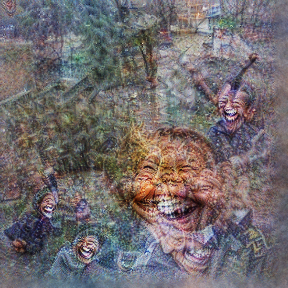
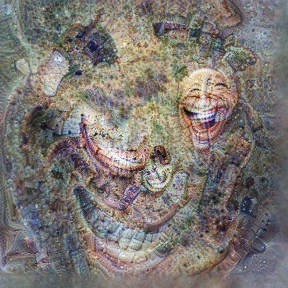

In [ ]:
# Diversity objective -> we should experiment more, results aren't that good

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy
image_path = f"results/feature_vis_diversity_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=2, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1.5 * objectives.diversity(layer_name) # we should experiment more

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(100,))

### **OpenAI faceted feature visualization**

In [ ]:
# Let's try the OpenAI faceted feature visualization (e.g. https://github.com/openai/CLIP-featurevis/blob/master/example_facets.py)

# We will write the code shortly... (we should send an email to the authors for the links or implement the style attrs, or fuck it)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/openai_faceted_feature_vis_{layer_name}_{neuron_channel_index}.png"

def load_npy(url): # load style attrs from urls
  response = requests.get(url)
  response.raise_for_status()
  return np.load(BytesIO(response.content))

facets = ["face", "text", "logo", "pose", "arch", "nature", "indoor"] # facets
style_attrs = [load_npy(f"https://openaipublic.blob.core.windows.net/clip/facets/RN50_4x/{layer_name}/{facet}_spatial.npy") for facet in facets] # style attributes (the urls doesn't work!)

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.channel(layer_name, neuron_channel_index) # objective
obj -= 1e2 * objectives.blur_alpha_each_step()
# ...

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Text feature visualization

In [ ]:
# 1st idea: gradient-based optimization directly on the text embeddings and clustering to transform them into tokens -> we don't expect this to have good results
# 2nd idea: naive brute force search algorithm with text manipulation actions (add token, remove token, substitute token), we can also incorporate a LM and a heuristic algorithm here -> we don't expect this to be very time-efficient
# 3rd idea: autoregressive/causal generation guided with a LM, along with a heuristic search method (e.g. hill climbing, beam search) -> needs caution to be efficient

# extra ideas: - use a pre-trained image captioning model to "guide" the search
#              - refine captions with multiple runs of the algorithm (we can use a combination of the aforementioned approaches)


def calculate_clip_similarity(clip_model, image, text):
  text_tokens = clip.tokenize([text]).to(device)
  with torch.no_grad():
    # image_features = clip_model.encode_image(image)
    # text_features = clip_model.encode_text(text_tokens)
    logits_per_image, logits_per_text = clip_model(image, text_tokens)
  return logits_per_text.cpu().numpy()[0][0] # it's the same
  # return logits_per_image.cpu().numpy()[0][0]


def text_similarity(text1, text2, sentence_transformer_model=None, clip_model=None):
  """
  Computes the similarity between two texts.
  """
  if sentence_transformer_model is not None: # sentence transformer
    embedding1 = sentence_transformer_model.encode(text1, convert_to_tensor=True)
    embedding2 = sentence_transformer_model.encode(text2, convert_to_tensor=True)
    similarity = torch.nn.functional.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).cpu()
  elif clip_model is not None: # clip model
    text1_tokens = clip.tokenize([text1]).to(device)
    text2_tokens = clip.tokenize([text2]).to(device)
    embedding1 = clip_model.encode_text(text1_tokens)
    embedding2 = clip_model.encode_text(text2_tokens)
    similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2).detach().cpu()
  return similarity[0].item()


# TODOs:
#  - experiment with different approaches, see also: https://arxiv.org/pdf/1610.02424.pdf
def diverse_beam_search(beams, beam_width, diversity_penalty, clip_model=None, sentence_transformer_model=None):
  """
  Beam search pruning with a diversity objective between sentences/beams.
  """
  total_beams = len(beams)
  if total_beams < beam_width:
    return sorted(beams, key=lambda x: x[1], reverse=True)
  num_groups = beam_width
  base_group_size = total_beams // num_groups
  extra_beams = total_beams % num_groups

  grouped_beams = []
  start_idx = 0
  for i in range(num_groups): # adjacent grouping approach, we expect that adjacent beams are likely to be similar
    current_group_size = base_group_size + (1 if i < extra_beams else 0)
    grouped_beams.append(beams[start_idx:start_idx + current_group_size])
    start_idx += current_group_size

  new_beams = []
  for group in grouped_beams:
    group_scores = {}
    for beam in group:
      score = beam[1]
      for other_beam in group:
        if beam != other_beam:
          similarity = text_similarity(beam[0], other_beam[0], sentence_transformer_model=sentence_transformer_model, clip_model=clip_model) # similarity between two texts
          score -= diversity_penalty * similarity # we add a diversity term based on similarity
      group_scores[beam] = score # diversity-augmented score
    best_beam = max(group_scores, key=group_scores.get) # "best" beam in this group based on clip score and diversity
    # new_beams.append((best_beam, group_scores[best_beam]))
    new_beams.append(best_beam)

  diverse_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)
  return diverse_beams

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 17.80it/s]



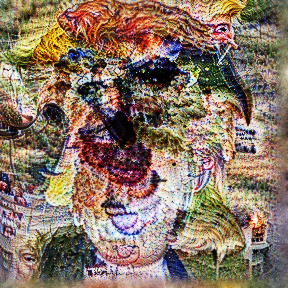

loading configuration file config.json from cache at /home/angelos/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.37.2",
  "

('it depicts the', 28.38)
('it depicts a', 28.48)
('it depicts you', 27.86)
('it depicts what', 27.7)
('it depicts a', 28.48)
('it depicts the', 28.38)
('it depicts me', 26.23)
('it depicts the', 28.38)
('it depicts the', 28.38)
('it depicts the', 28.38)
10
('it depicts a human', 29.3)
('it depicts a man', 30.67)
('it depicts a "', 29.02)
('it depicts a small', 27.9)
('it depicts a series', 29.19)
('it depicts a series', 29.19)
('it depicts a beautiful', 29.34)
('it depicts a white', 27.77)
('it depicts a small', 27.9)
('it depicts a group', 28.14)
('it depicts a scene', 28.92)
('it depicts a large', 28.73)
('it depicts a man', 30.67)
('it depicts a group', 28.14)
('it depicts a high', 28.52)
('it depicts a series', 29.19)
('it depicts a world', 29.25)
('it depicts a time', 28.67)
('it depicts a very', 28.95)
('it depicts a person', 28.77)
('it depicts the "', 29.36)
('it depicts the people', 29.25)
('it depicts the story', 29.45)
('it depicts the face', 28.58)
('it depicts the same', 

KeyboardInterrupt: 

In [ ]:
# A simple implementation (3rd idea)

# TODOs:
#  - experiment with different strategies for scoring and selecting beams.
#    For example, we can incorporate additional metrics or adjust the balance between the language model's likelihood and the CLIP similarity (e.g., ideally we need diversity for different sequences).
#    See also here: https://huggingface.co/docs/transformers/en/generation_strategies different decoding strategies we can use. Keep in mind that we need a custom solution
#    in order to incorporate the clip similarity objective.
#  - experiment with the generation parameters (temperature, top_k, top_p)
#  - experiment with different and bigger LMs
#  - "design" custom initial prompts to guide the search
#  - what about human-in-the-loop?
#  - implement an appropriate stopping criteria (it needs to be efficient and have coherent results)
def find_maximal_text(neuron, clip_model, language_model="gpt2", steps=12, branching_factor=10, beam_width=100, initial_text=None, verbose=True):
  '''
  Finds the maximal text that corresponds to a given neuron.

  This is a custom algorithm with an autoregressive/causal logic for guided generation, through a language model (such as GPT2), along with a heuristic search method (here we use a variant of beam search decoding).

  Parameters
  ----------
  neuron: the layer and neuron/channel index in the form layer:index (e.g., layer4_5_bn3:1512) to find the maximal text for
  clip_model: the CLIP model
  language_model: the language model we are using to constrain the generation (e.g., gpt2)
  steps: the number of iterations to run the search algorithm for
  branching_factor: for each hypothesis (sentence) we sample branching_factor next tokens
  beam_width: beam search pruning based on the CLIP similarity objective
  initial_text: custom initial prompt to "guide" the search
  verbose: True, in order to see the intermediate paths of the search

  Returns
  -------
    the maximal text as string
  '''
  # Image that activates the most a given neuron via activation maximization
  layer_name, neuron_channel_index = neuron.split(":")
  neuron_channel_index = int(neuron_channel_index)
  batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
  obj = objectives.channel(layer_name, neuron_channel_index)
  tforms = [ # we can experiment with these transformations
          transform.pad(2, mode='constant', constant_value=.5),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
          transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
          transform.jitter(2)
  ]
  image = render.render_vis(clip_model.visual, obj, batch_param_f, transforms=tforms, show_inline=True, thresholds=(512,))[0]
  image = Image.fromarray((image * 255).astype(np.uint8).squeeze(0))
  image = preprocess(image).unsqueeze(0).to(device) # clip preprocessing
  # image = Image.open(data_path + "dog_cat.jpg") # for testing
  # image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

  # Language model
  if language_model == "gpt2":
    lm = GPT2LMHeadModel.from_pretrained(language_model).to(device)
  # elif language_model == "bert-base-uncased": # not good for generation
  #   lm = BertLMHeadModel.from_pretrained(language_model).to(device)
  # elif language_model == "t5-small": # not good, this is mainly for translation
  #   lm = T5ForConditionalGeneration.from_pretrained(language_model).to(device)
  else:
    lm = AutoModel.from_pretrained(language_model).to(device)
  lm_tokenizer = AutoTokenizer.from_pretrained(language_model) # tokenizer

  # Searching
  if initial_text is None:
    initial_text = "it depicts"
  beams = [(initial_text, 0.0)] # frontier, in which each state is in the form: (text, clip similarity score)
  for _ in range(steps):
    new_beams = []
    for text, score in beams:
      input_ids = lm_tokenizer.encode(text, add_special_tokens=False, return_tensors="pt").to(device)
      # input_ids = lm_tokenizer(text, return_tensors="pt").input_ids.to(device)
      attention_mask = input_ids.ne(lm_tokenizer.pad_token_id).int() if lm_tokenizer.pad_token_id is not None else None

      outputs = lm.generate(
        input_ids,
        attention_mask=attention_mask,
        pad_token_id=lm_tokenizer.pad_token_id if lm_tokenizer.pad_token_id is not None else lm_tokenizer.eos_token_id,
        do_sample=True,
        temperature=1.1, # temperature sampling
        top_k=50, # top-k sampling
        top_p=0.95, # nucleus sampling
        return_dict_in_generate=True,
        output_scores=True,
        num_return_sequences=branching_factor, # sample branching_factor next tokens
        max_new_tokens=1
      )
      logits = outputs.scores[-1] # logits for the last generated token across all sequences

      for i in range(branching_factor): # iterate through the branching_factor number of options generated at this step
        token_idx = outputs.sequences[:, -1][i] # index of the last generated token
        token = lm_tokenizer.decode(token_idx, skip_special_tokens=True)
        new_text = text + token
        new_clip_score = calculate_clip_similarity(clip_model, image, new_text)
        new_score = new_clip_score
        new_beams.append((new_text, new_score))
        if verbose:
          print((new_text, new_score))

    # beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width] # beam search pruning based on the CLIP similarity objective
    # sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
    beams = diverse_beam_search(new_beams, beam_width=beam_width, diversity_penalty=0.1, clip_model=clip_model, sentence_transformer_model=None) # beam search with a diversity objective

  # Return the top-m sentences that maximally correspond to the given neuron
  m = 50
  maximal_text = sorted(beams, key=lambda x: x[1], reverse=True)[:m]

  return maximal_text

maximal_text = find_maximal_text("layer4_5_bn3:89", model, language_model="gpt2", steps=12, branching_factor=10, beam_width=100, initial_text="it depicts", verbose=True)

In [ ]:
# Let's examine the text feature visualization results

k = 20 # top-k results
for i in range(k):
  print(f"Maximal text: {maximal_text[i]}")

Maximal text: ('it depicts an extremely powerful man.\n\n\nFor those unaware:', 41.53)
Maximal text: ('it depicts a "bigot\'s eye."\n\n\n(CNN', 41.12)
Maximal text: ('it depicts the American president in a new light.\n\n\nFrom', 40.75)
Maximal text: ('it depicts the face of the president as a white supremacist, a view', 40.72)
Maximal text: ('it depicts what the Russian president saw and did when Trump was sworn in', 40.38)
Maximal text: ('it depicts an evil group of humans and other alien races coming to power', 39.66)
Maximal text: ('it depicts the current climate. It represents all parts of history.\n', 39.56)
Maximal text: ("it depicts what's happening:\n\n\nHere's the original artwork", 39.53)
Maximal text: ('it depicts the man as more evil, more destructive, more reckless.', 39.38)
Maximal text: ('it depicts the most extraordinary event of history.\n\n\nWhat follows', 39.34)
Maximal text: ('it depicts a typical American man, "his family" or "government', 39.3)
Maximal text: ('it 

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.37it/s]



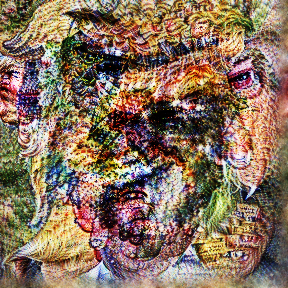

loading configuration file config.json from cache at /home/angelos/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/angelos/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Generate config

Streaming output truncated to the last 5000 lines.
('all he said', 28.19)
('all he.', 27.6)
('all he on', 27.17)
('all he "', 26.05)
('all he she', 25.11)
('all he is', 27.58)
('all he no', 27.39)
('all he -', 26.44)
('all hes', 26.83)
('all he s', 26.92)
('without all he depicts', 30.47)
('. all he depicts', 29.8)
('/ all he depicts', 29.83)
('all all he depicts', 29.56)
('( all he depicts', 29.16)
('and all he depicts', 29.75)
('v all he depicts', 29.53)
('including all he depicts', 30.52)
('##es all he depicts', 28.66)
('##e all he depicts', 29.64)
('all after he depicts', 30.16)
('all and he depicts', 29.53)
('all in he depicts', 27.84)
('all what he depicts', 31.2)
('all " he depicts', 29.17)
('all but he depicts', 29.86)
('all the he depicts', 27.94)
('all on he depicts', 28.45)
('all as he depicts', 28.98)
('all these he depicts', 28.28)
('all he not depicts', 29.17)
('all he, depicts', 29.81)
('all he. depicts', 29.33)
('all he is depicts', 29.83)
('all he : depicts', 28.62)
('

KeyboardInterrupt: 

In [ ]:
# A simple implementation (2nd idea)

def heuristic_score(clip_model, lm, lm_tokenizer, image, text):
  """
  The heuristic we are using for the search algorithm (a combination of the CLIP similarity and the LM score).
  """
  # Calculate CLIP score (logits) for image-text similarity
  clip_score = calculate_clip_similarity(clip_model, image, text)

  # Calculate LM score for text coherence
  input_ids = lm_tokenizer.encode(text, return_tensors="pt").to(device)
  outputs = lm(input_ids, labels=input_ids)
  loss = outputs.loss
  lm_score = torch.exp(-loss).item() # cost = -log(prob), why?

  # Combine scores (we can experiment with different approaches)
  combined_score = (clip_score + lm_score) / 2
  return combined_score


def lm_sentence_score(sentence, lm, lm_tokenizer):
  """
  Function to calculate the LM score for a sentence.
  """
  input_ids = lm_tokenizer.encode(sentence, add_special_tokens=False, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = lm(input_ids, labels=input_ids)
  loss = outputs.loss
  return -loss.item()


def generate_actions(tokens, lm_tokenizer):
  """
  Generates the text manipulation actions at each step (brute force approach, we search all the vocabulary).
  """
  actions = []

  # Generate "add" actions
  for i in range(len(tokens) + 1):
    for token in lm_tokenizer.get_vocab().keys():
      new_tokens = tokens[:i] + [token] + tokens[i:]
      actions.append(('add', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  # Generate "remove" actions
  for i in range(len(tokens)):
    new_tokens = tokens[:i] + tokens[i+1:]
    actions.append(('remove', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  # Generate "substitute" actions
  for i in range(len(tokens)):
    for token in lm_tokenizer.get_vocab().keys():
      new_tokens = tokens[:i] + [token] + tokens[i+1:]
      actions.append(('substitute', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  return actions


def sample_tokens_from_logits(logits, num_samples=3, top_k=50, top_p=0.95, temperature=1.1):
  """
  Sample multiple tokens from logits with various sampling strategies (top-k, nucleus and temperature sampling).
  """
  logits = logits / temperature # temperature sampling
  probabilities = F.softmax(logits, dim=-1)

  if top_k > 0:# top-k sampling
    indices_to_remove = probabilities < torch.topk(probabilities, top_k)[0][..., -1, None]
    probabilities[indices_to_remove] = 0

  if top_p < 1.0: # nucleus sampling
    sorted_indices = torch.argsort(probabilities, descending=True)
    cumulative_probs = torch.cumsum(torch.sort(probabilities, descending=True)[0], dim=-1)
    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = False
    for batch_idx in range(logits.size(0)):
      indices_to_remove = sorted_indices[batch_idx][sorted_indices_to_remove[batch_idx]]
      probabilities[batch_idx, indices_to_remove] = 0

  sampled_token_ids = torch.multinomial(probabilities, num_samples)
  return sampled_token_ids


def generate_lm_actions(tokens, lm, lm_tokenizer, num_return=10, top_k=50, top_p=0.95, temperature=1.1):
  """
  Limit the search space by utilizing a language model (e.g., a BERT model) with a masked token prediction technique (MLM).
  """
  actions = []
  mask_token = lm_tokenizer.mask_token

  # "Substitution" super-action
  for i, original_token in enumerate(tokens):
    masked_tokens = tokens[:i] + [mask_token] + tokens[i+1:]
    masked_text = lm_tokenizer.convert_tokens_to_string(masked_tokens)
    input_ids = lm_tokenizer.encode(masked_text, add_special_tokens=False, return_tensors="pt").to(device)
    mask_token_index = torch.where(input_ids == lm_tokenizer.mask_token_id)[1]

    with torch.no_grad():
      predictions = lm(input_ids)[0]
    logits = predictions[0, mask_token_index, :]

    sampled_token_ids = sample_tokens_from_logits(logits, num_samples=num_return, top_k=top_k, top_p=top_p, temperature=temperature) # sampling
    for token_id in sampled_token_ids.squeeze().tolist():
      token = lm_tokenizer.decode([token_id], skip_special_tokens=True)
      new_tokens = tokens[:i] + [token] + tokens[i+1:]
      actions.append(('substitute', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

    # top_token_ids = torch.topk(logits, num_return, dim=1).indices[0].tolist() # pick the top-k tokens
    # for token_id in top_token_ids:
    #   token = lm_tokenizer.decode([token_id], skip_special_tokens=True)
    #   new_tokens = tokens[:i] + [token] + tokens[i+1:]
    #   actions.append(('substitute', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  # "Add" super-action
  for i in range(len(tokens) + 1):
    masked_tokens = tokens[:i] + [mask_token] + tokens[i:]
    masked_text = lm_tokenizer.convert_tokens_to_string(masked_tokens)
    input_ids = lm_tokenizer.encode(masked_text, add_special_tokens=False, return_tensors="pt").to(device)
    mask_token_index = torch.where(input_ids == lm_tokenizer.mask_token_id)[1]

    with torch.no_grad():
      predictions = lm(input_ids)[0]
    logits = predictions[0, mask_token_index, :]

    sampled_token_ids = sample_tokens_from_logits(logits, num_samples=num_return, top_k=top_k, top_p=top_p, temperature=temperature) # sampling
    for token_id in sampled_token_ids.squeeze().tolist():
      token = lm_tokenizer.decode([token_id], skip_special_tokens=True)
      new_tokens = tokens[:i] + [token] + tokens[i:]
      actions.append(('add', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

    # top_token_ids = torch.topk(logits, num_return, dim=1).indices[0].tolist()  # pick the top-k tokens
    # for token_id in top_token_ids:
    #   token = lm_tokenizer.decode([token_id], skip_special_tokens=True)
    #   new_tokens = tokens[:i] + [token] + tokens[i:]
    #   actions.append(('add', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  # "Remove" super-action (TODO: can we think of a "smarter" approach? e.g., we can consider a more dynamic criteria based on the context or relevance of tokens)
  len_threshold = 14 # length threshold to enable the "remove" super-action
  if len(tokens) >= len_threshold:
    for i in range(len(tokens)):
      new_tokens = tokens[:i] + tokens[i+1:]
      actions.append(('remove', i, lm_tokenizer.convert_tokens_to_string(new_tokens)))

  return actions


# TODOs:
#  - experiment with the generation parameters (temperature, top_k, top_p)
#  - experiment with different and bigger LMs
#  - we want diversity for different sequences/beams
def find_maximal_text(neuron, clip_model, language_model="bert-based-uncased", steps=15, branching_factor=10, beam_width=100, initial_text=None, verbose=True):
  '''
  Finds the maximal text that corresponds to a given neuron.

  This is a different approach, in which we utilize a naive brute force search algorithm (or a heuristic algorithm, e.g., beam search) with text manipulation actions (add token, remove token, substitute token).
  We limit the search space by using a LM (with a masked token prediction task for generating the plausible actions).

  Parameters
  ----------
  neuron: the layer and neuron/channel index in the form layer:index (e.g., layer4_5_bn3:1512) to find the maximal text for
  clip_model: the CLIP model
  language_model: the language model we are using to limit the search space with a masked token prediction task (e.g., a BERT model)
  steps: the number of iterations to run the search algorithm for
  branching_factor: for each hypothesis (sentence) and action (add, substitute) we sample branching_factor tokens
  beam_width: beam search pruning based on a heuristic value
  initial_text: custom initial prompt to "guide" the search
  verbose: True, in order to see the intermediate paths of the search

  Returns
  -------
    the maximal text as string
  '''
  # Image that activates the most a given neuron via activation maximization
  layer_name, neuron_channel_index = neuron.split(":")
  neuron_channel_index = int(neuron_channel_index)
  batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
  obj = objectives.channel(layer_name, neuron_channel_index)
  tforms = [ # we can experiment with these transformations
          transform.pad(2, mode='constant', constant_value=.5),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.jitter(4),
          transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
          transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
          transform.jitter(2)
  ]
  image = render.render_vis(clip_model.visual, obj, batch_param_f, transforms=tforms, show_inline=True, thresholds=(512,))[0]
  image = Image.fromarray((image * 255).astype(np.uint8).squeeze(0))
  image = preprocess(image).unsqueeze(0).to(device) # clip preprocessing
  # image = Image.open(data_path + "dog_cat.jpg") # for testing
  # image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

  # Language model
  if language_model == "gpt2":
    lm = GPT2LMHeadModel.from_pretrained(language_model).to(device)
  elif language_model == "bert-base-uncased": # not good for generation, but for MLM
    lm = BertForMaskedLM.from_pretrained(language_model).to(device)
  # elif language_model == "t5-small": # not good, this is mainly for translation
  #   lm = T5ForConditionalGeneration.from_pretrained(language_model).to(device)
  else:
    lm = AutoModel.from_pretrained(language_model).to(device)
  lm_tokenizer = AutoTokenizer.from_pretrained(language_model) # tokenizer

  # Searching
  if initial_text is None:
    initial_text = "it depicts"
  beams = [(initial_text, 0.0)] # frontier, in which each state is in the form: (text, heuristic value)
  for _ in range(steps):
    new_beams = []
    for text, score in beams:
      input_ids = lm_tokenizer.encode(text, add_special_tokens=False, return_tensors="pt").to(device)
      # input_ids = lm_tokenizer(text, return_tensors="pt").input_ids.to(device)
      tokens = lm_tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
      tokens = [tokens] if isinstance(tokens, str) else tokens
      # actions = generate_actions(tokens, lm_tokenizer) # generate potential actions, naive (brute force) action generation without a LM
      actions = generate_lm_actions(tokens, lm, lm_tokenizer, num_return=branching_factor, top_k=100, top_p=1, temperature=1.1) # action generation constrained with a LM
      for action in actions:
        _, _, new_text = action
        # new_score = heuristic_score(clip_model, lm, lm_tokenizer, image, new_text) # -> this can be combined with the naive brute force action generation
        new_score = calculate_clip_similarity(clip_model, image, new_text)
        new_beams.append((new_text, new_score))
        if verbose:
          print((new_text, new_score))

    # beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width] # beam search pruning based on the CLIP similarity objective (or a heuristic in general)
    # sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
    beams = diverse_beam_search(new_beams, beam_width=beam_width, diversity_penalty=0.1, clip_model=clip_model, sentence_transformer_model=None) # beam search with a diversity objective

  # Return the top-m sentences that maximally correspond to the given neuron
  m = 50
  maximal_text = sorted(beams, key=lambda x: x[1], reverse=True)[:m]

  return maximal_text

maximal_text = find_maximal_text("layer4_5_bn3:89", model, language_model="bert-base-uncased", steps=10, branching_factor=10, beam_width=100, initial_text="it depicts", verbose=True)

In [ ]:
# Let's examine the text feature visualization results

k = 20 # top-k results
for i in range(k):
  print(f"Maximal text: {maximal_text[i]}")

Maximal text: ('2016 digital effect digital artwork called this election depicts towards him a', 46.3)
Maximal text: ('music digital artwork transparency artwork artwork called the election him a', 46.22)
Maximal text: ('music digital perspective graphic artwork called him " this election. a', 46.2)
Maximal text: ('2016 music 1 % digital artwork called this election depicts round him a', 45.94)
Maximal text: ('world digital artwork called him this election president. a 6', 45.84)
Maximal text: ('2016 music digital artwork called 2016 election depicts him having a', 45.84)
Maximal text: ('2016 music digital artwork artwork called " this election shot depicts him a', 45.8)
Maximal text: ("2016 music digital artwork artwork called this election depicts ' him on a", 45.78)
Maximal text: ('him digital art art transparency artwork called this 2016 election depicts a', 45.75)
Maximal text: ('2016 music elements digital artwork artwork " called this election depicts him a', 45.75)
Maximal text

In [ ]:
# Experiment with the action sampling hyperparameters

text = "this depicts a picture of donald"
lm = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
lm_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

input_ids = lm_tokenizer.encode(text, add_special_tokens=False, return_tensors="pt").to(device)
# input_ids = lm_tokenizer(text, return_tensors="pt").input_ids.to(device)
tokens = lm_tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
tokens = [tokens] if isinstance(tokens, str) else tokens
# actions = generate_actions(tokens, lm_tokenizer) # generate potential actions, naive (brute force) action generation without a LM
actions = generate_lm_actions(tokens, lm, lm_tokenizer, num_return=15, top_k=200, top_p=1, temperature=1.1) # action generation constrained with a LM
actions

loading configuration file config.json from cache at /home/angelos/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/angelos/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Generate config

[('substitute', 0, 'but depicts a picture of donald'),
 ('substitute', 0, 'act depicts a picture of donald'),
 ('substitute', 0, 'an depicts a picture of donald'),
 ('substitute', 0, '( depicts a picture of donald'),
 ('substitute', 0, '##s depicts a picture of donald'),
 ('substitute', 0, 'may depicts a picture of donald'),
 ('substitute', 0, 'story depicts a picture of donald'),
 ('substitute', 0, 'who depicts a picture of donald'),
 ('substitute', 0, 'other depicts a picture of donald'),
 ('substitute', 0, '/ depicts a picture of donald'),
 ('substitute', 0, 'elements depicts a picture of donald'),
 ('substitute', 0, 'for depicts a picture of donald'),
 ('substitute', 0, 'of depicts a picture of donald'),
 ('substitute', 0, 'they depicts a picture of donald'),
 ('substitute', 0, 'on depicts a picture of donald'),
 ('substitute', 1, 'this either a picture of donald'),
 ('substitute', 1, 'this notes a picture of donald'),
 ('substitute', 1, 'this ask a picture of donald'),
 ('substitu

In [ ]:
# A simple implementation (1st idea)

# We will write the code shortly... (if we don't have good results, we will omit it)

## Semantic relations in multimodal models

In [125]:
# Semantic relation of image-based word embeddings -> we should experiment also with other CLIP models

# Words to rasterize and compare
# vocabulary = words.words()[:500] # from nltk
# or "manually":
vocabulary = ["german", "spanish", "danke", "ください", "医者", "english", "japanese", "africa", "black", "idiot", "japan", "うし", "cattle", "food", "スシ", "すし", "sushi", "こんにちは", "konichiwa", "indonesia", "selamat", "congratulations", "congrats", "gratulieren", "animal", "trump", "hi", "hello", "texas", "guns", "supremacy", "terrorist", "muslims", "bush", "joe biden", "fell down", "dimentia", "sleepy", "car", "america", "donald trump", "republicans", "water", "lake", "god", "bible", "motorcycle", "wall", "us", "thank you", "merci", "france", "london", "paris", "england", "europe", "mike pence"]
# exclude = ["japan", "うし", "cattle", "food", "スシ", "すし", "sushi", "こんにちは"]
exclude = []
filtered_vocabulary = [word for word in vocabulary if word not in exclude]

word_tensors = torch.cat([text_to_tensor(word, font_path=data_path + "NotoSansJP-Regular.ttf") for word in vocabulary], dim=0)
with torch.no_grad(): # image-based embeddings
  rasterized_text_embeddings = model.encode_image(word_tensors) # RN
  # rasterized_text_embeddings, _, _ = model.encode_image(word_tensors) # ViT
rasterized_text_embeddings = rasterized_text_embeddings - torch.mean(rasterized_text_embeddings, dim=0, keepdim=True) # subtract off the average over words for removing generic “black text on white background” features

text_inputs = clip.tokenize(vocabulary).to(device)
with torch.no_grad(): # word embeddings
  real_text_embeddings = model.encode_text(text_inputs)

In [126]:
# Find the most semantically close (similar) words based on the cosine similarity for the target word (top-k)

target_word = "danke"
target_word_index = vocabulary.index(target_word)
target_word_embedding = rasterized_text_embeddings[target_word_index].unsqueeze(0)
cosine_similarities_rasterized = torch.nn.functional.cosine_similarity(target_word_embedding, rasterized_text_embeddings)
cosine_similarities_real_text = torch.nn.functional.cosine_similarity(target_word_embedding, real_text_embeddings)

k = 5
sorted_indices_rasterized = torch.argsort(cosine_similarities_rasterized, descending=True)
sorted_indices_real_text = torch.argsort(cosine_similarities_real_text, descending=True)

print(f"Top-{k} similar words to '{target_word}' in rasterized text:")
for i in range(1, k + 1):
  index = sorted_indices_rasterized[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_rasterized[index].item()}")

print(f"\nTop-{k} similar words to '{target_word}' in real text:")
for i in range(1, k + 1):
  index = sorted_indices_real_text[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_real_text[index].item()}")

# We should discuss about the modality gap problem, based also on our results/findings here

Top-5 similar words to 'danke' in rasterized text:
gratulieren: 0.55859375
merci: 0.386474609375
thank you: 0.347412109375
german: 0.25048828125
congrats: 0.23681640625

Top-5 similar words to 'danke' in real text:
gratulieren: 0.20751953125
german: 0.1593017578125
merci: 0.0946044921875
europe: 0.09075927734375
food: 0.08111572265625


In [ ]:
# Word arithmetic - analogies (a:b::a∗:b∗, a is to b as a∗ is to b∗ - parallelogram method)

a = "english"
b = "thank you"
a_star = "german"
a_index = vocabulary.index(a)
b_index = vocabulary.index(b)
a_star_index = vocabulary.index(a_star)
a_embedding = rasterized_text_embeddings[a_index].unsqueeze(0)
b_embedding = rasterized_text_embeddings[b_index].unsqueeze(0)
a_star_embedding = rasterized_text_embeddings[a_star_index].unsqueeze(0)
cosine_similarities_rasterized = torch.nn.functional.cosine_similarity(b_embedding - a_embedding + a_star_embedding, rasterized_text_embeddings)

# Find the top-m results for the analogy
m = 5
sorted_indices_rasterized = torch.argsort(cosine_similarities_rasterized, descending=True)
print(f"{a} is to {b} as {a_star} is to:")
for i in range(1, m + 1):
  index = sorted_indices_rasterized[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_rasterized[index].item()}")

# We can experiment also with mixed arithmetic of words and images (if time permits, or just we can mention it)

english is to thank you as german is to:
danke: 0.4677734375
gratulieren: 0.439208984375
congrats: 0.406005859375
congratulations: 0.3916015625
merci: 0.357666015625


## Emotion composition

In [ ]:
# We will write the code shortly... (if time permits) -> probably in a future extended work

## CLAP model

In general, we plan to explore similar undiscovered multimodal neurons that may exist in other models as well, such as **audio** and **music** understanding, and also not limited to contrastive learning approaches and retrieval models.

Here, we will try to explore multimodal neurons in the CLAP (https://arxiv.org/pdf/2206.04769.pdf) model.

**We will probably delve into it in a future extended work.**

In [ ]:
# CLAP model (if time permits)

# MS CLAP
model, tokenizer, args = CLAP(version='2023', use_cuda=True).load_clap() # -> changed the config file to use the Cnn14 architecture

# LAION CLAP
# model = laion_clap.CLAP_Module(enable_fusion=False, device=device) # -> the audio side here is implemented with transformers
# model.load_ckpt()

model.to(device).eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
# Audio side of the CLAP model

# audio_side = model.model.audio_branch # LAION CLAP
audio_side = model.audio_encoder # MS CLAP

In [ ]:
# Audio side model layers

layers = get_model_layers(audio_side)
print(layers)

['base', 'base_spectrogram_extractor', 'base_spectrogram_extractor_stft', 'base_spectrogram_extractor_stft_conv_real', 'base_spectrogram_extractor_stft_conv_imag', 'base_logmel_extractor', 'base_bn0', 'base_conv_block1', 'base_conv_block1_conv1', 'base_conv_block1_conv2', 'base_conv_block1_bn1', 'base_conv_block1_bn2', 'base_conv_block2', 'base_conv_block2_conv1', 'base_conv_block2_conv2', 'base_conv_block2_bn1', 'base_conv_block2_bn2', 'base_conv_block3', 'base_conv_block3_conv1', 'base_conv_block3_conv2', 'base_conv_block3_bn1', 'base_conv_block3_bn2', 'base_conv_block4', 'base_conv_block4_conv1', 'base_conv_block4_conv2', 'base_conv_block4_bn1', 'base_conv_block4_bn2', 'base_conv_block5', 'base_conv_block5_conv1', 'base_conv_block5_conv2', 'base_conv_block5_bn1', 'base_conv_block5_bn2', 'base_conv_block6', 'base_conv_block6_conv1', 'base_conv_block6_conv2', 'base_conv_block6_bn1', 'base_conv_block6_bn2', 'base_fc1', 'base_fc_audioset', 'projection', 'projection_linear1', 'projection

In [ ]:
# Define the layer and neuron/channel for feature visualization -> this doesn't work, we will find a way to play with audio and specs or through the VL-InterpreT tool

# We will write the code shortly...

layer_name = "base_conv_block6_bn2"
neuron_channel_index = 6

batch_param_f = lambda: param.image(256, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(audio_side, obj, batch_param_f, show_inline=True)
# _ = render.render_vis(audio_side, "layer3_3_conv3:168", show_inline=True) # or this

## Interpretability in transformer-based architectures

In [7]:
# TODOs:
# - attention and hidden states in synthetic or natural images with multiple related (quasi-multimodal) concepts for the CLIP ViT model
#   * robustness to fonts and font size in synthetic images with rastered captions
#   * image text in the wild (e.g. signs) !
#   * experiment only with text, e.g. -ing detectors, semantics, etc. !
#   * interleaved synthetic text to image (blended, robustness)
#   * experiment with patch size (resolution)
#   * instead of "neurons" (channels in cnn architectures) find heads that capture a semantic space (e.g. -ing detector, high-level semantics, etc.) !
#   * why and how this works? needs further discussion and insights
#   * image-to-text and text-to-image attention isn't "symmetric"
#   * "perceptive field" (attendance in bigger scale) changes as we go deeper
#   * we see that text attends at first layers to itself and other texts (probably of background, font, different pixel space in rastered text than the natural image)
#   * again, why this is working? and does it depend on the dataset CLIP was trained on (natural text in images and contrastive objective, similar concepts "brought" together)?
#   * experiment also with MetaCLIP, etc., for different datasets
#   * seems that dataset is crucial, we will experiment more
#   ("!" means important TODOs)

# - interpretability of cross-modal attentions for "true" multimodal models, e.g. MuLaP or ViLBERT (if time permits) -> probably in a future extended work
#   Also, our current focus is the interpretability of the CLIP model (in a "unimodal" approach), which doesn't contain cross-modal attentions in its architecture

### **CLIP transformer-based (ViT) model**

In [8]:
# Helper functions to show the patches and attention weights

def plot_patch(n_patch, patch_size, input_image=None):
  '''
  Plots the selected patch over the image.

  Parameters
  ----------
  n_patch: index of selected patch
  patch_size: patch resolution
  input_image: the image to overlay the patch on
  '''
  assert patch_size == 14 or patch_size == 16 or patch_size == 32, "Patch size can be 14, 16 or 32."

  image_size = (224, 224)
  square_size = patch_size
  x1 = n_patch // (224 / patch_size)
  x2 = n_patch % (224 / patch_size)
  patch_number = (int(x1), int(x2))  # (row, column) - 0-indexed

  image = np.zeros((image_size[0], image_size[1], 4), dtype=np.uint8)
  image[:, :, 3] = 0  # fully transparent image

  x0 = patch_number[1] * square_size
  y0 = patch_number[0] * square_size
  x1 = x0 + square_size
  y1 = y0 + square_size
  image[y0:y1, x0:x1, :] = [0, 0, 255, 128]  # blue square with 50% opacity

  if input_image is not None:
    plt.imshow(input_image.transpose(1, 2, 0))

  plt.imshow(image)
  plt.axis('off')
  plt.show()


def plot_attention_map(attention_weights, image, patch_size, patch, layer, head, attn_map=False, log=True):
  '''
  Plots the attention map over the given image.

  Parameters
  ----------
  attention_weights: the attention map of shape [layers, heads, number of patches + 1, number of patches + 1] (includes the classification patch)
  image: the preprocessed image of shape (224, 224)
  patch_size: size of patch used
  layer: selected layer for the attention map (index starts from 1)
  patch: selected patch to view its attention weights (index starts from 1)
  head: attention head selected which can be set to None to take the average of all the heads (index starts from 1)
  attn_map: plot the attention map alone after the image
  log: show attention weights in log scale
  '''
  ATTN_MAP_SCALE_FACTOR = patch_size

  layer_attn = attention_weights[layer - 1]
  layer_attn = layer_attn.squeeze(0)
  layer_attn = np.array(layer_attn)

  if head == None or head < 1:
    # get the mean attention of all the heads in the layer
    layer_attn = np.mean(layer_attn, axis=0)
  else:
    layer_attn = layer_attn[head - 1]

  layer_attn_patch = layer_attn[patch + 1, :]
  number_of_patches = int(224 / patch_size)
  img_attn = scipy.ndimage.zoom(layer_attn_patch[1:].reshape(number_of_patches, number_of_patches).astype(np.float64), ATTN_MAP_SCALE_FACTOR, order=1) # smoothing

  image_data = np.transpose(image, (1, 2, 0)) # [w, h, channels]
  plt.figure(figsize=(6, 6))
  plt.imshow(image_data)

  if log: # log scale
    img_attn = np.log2(img_attn)

  plt.imshow(img_attn, alpha=0.7)
  plot_patch(patch, patch_size=patch_size) # show patch

  if attn_map == True:
    plt.figure()
    plt.imshow(img_attn)
    plt.axis('off')

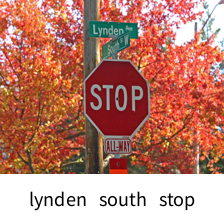

In [9]:
# Create a synthetic image with rastered text caption having multiple related (multimodal) concepts

def combine_image_with_caption(true_image_path, caption, combined_image_path, font_size=20, image_size=(224, 224), caption_height=50):
  true_image = Image.open(true_image_path)
  true_image_resized = true_image.resize((image_size[0], image_size[1] - caption_height))
  caption_image = text_to_image(caption, font_size=font_size, image_size=(image_size[0], caption_height), vertical_offset=-1, font_path=data_path + "NotoSansJP-Regular.ttf")
  combined_image = Image.new("RGB", image_size, "white")
  combined_image.paste(true_image_resized, (0, 0))
  combined_image.paste(caption_image, (0, image_size[1] - caption_height))
  combined_image.save(combined_image_path)
  return combined_image

combine_image_with_caption(data_path + "stop_sign_labels.jpg", "lynden   south   stop", data_path + "stop_sign_labels_captioned.jpg", font_size=18, image_size=(224, 224), caption_height=50)

In [ ]:
# Load the CLIP (ViT) model

patch_size = 16 # (patch_size, patch_size) is the resolution of each image patch
model, preprocess = clip.load(f"ViT-B/{patch_size}", device=device)
# model, preprocess = AutoModel.from_pretrained("facebook/metaclip-b32-400m"), AutoProcessor.from_pretrained("facebook/metaclip-b32-400m") # MetaCLIP
num_layers = 12

vision_side = model.visual # vision side
# vision_side = model.vision_model # MetaCLIP

vision_side.eval()

image = preprocess(Image.open(data_path + "usa_china_captioned.jpg")).unsqueeze(0).to(device) # image to interpret
with torch.no_grad(): # compute hidden states and attention weights
  image_features, hidden_states, attention_weights = vision_side(image.type(model.dtype))
image, hidden_states, attention_weights = image.squeeze(0).cpu().numpy(), tuple(tensor.cpu().numpy() for tensor in hidden_states), tuple(tensor.cpu().numpy() for tensor in attention_weights)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

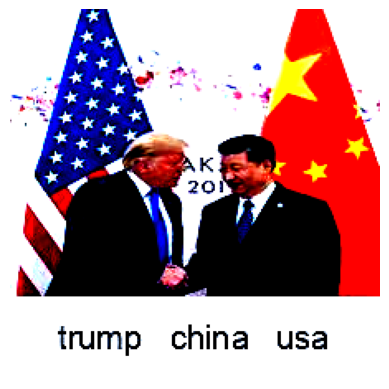

In [ ]:
# Show the image we want to interpret

plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


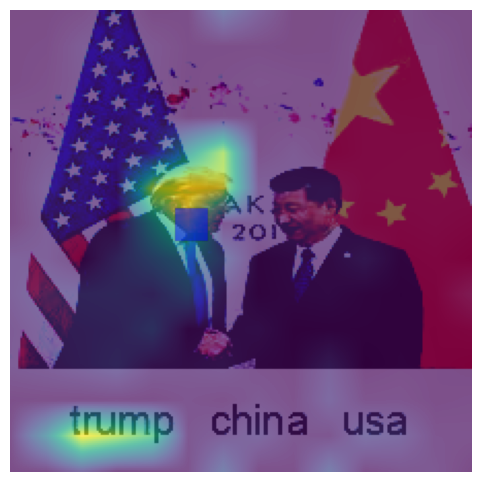

In [ ]:
# Show the attendance (attention weights) between patches

plot_attention_map(attention_weights, image, patch_size=patch_size, patch=89, layer=12, head=None, attn_map=False, log=False)

In [ ]:
# Show attendance as we go "deeper"

for layer in range(1, num_layers + 1):
  plot_attention_map(attention_weights, image, patch_size=patch_size, patch=89, layer=layer, head=None, attn_map=False)

Output hidden; open in https://colab.research.google.com to view.

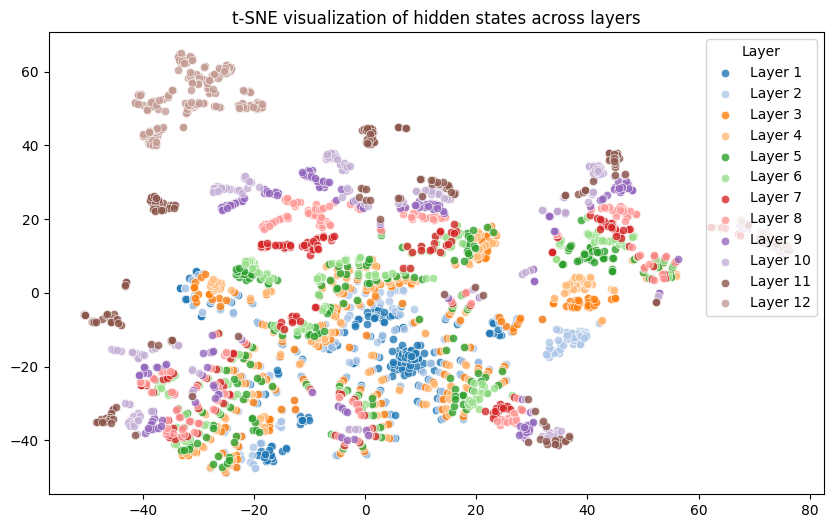

In [ ]:
# Visualize hidden states (t-SNE)

# Concatenate all hidden states across all layers
num_patches_per_layer = int((224 / patch_size)**2)
hidden_states_vis = [hidden_state.squeeze(0)[1:] for hidden_state in hidden_states[:num_layers]]
all_hidden_states = np.concatenate(hidden_states_vis, axis=0)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_hidden_states)

# t-SNE visualization of hidden states across layers
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab20", n_colors=len(hidden_states_vis))
for i, layer_hidden_states in enumerate(hidden_states_vis):
  start_idx = i * num_patches_per_layer
  end_idx = start_idx + num_patches_per_layer
  layer_color = palette[i]
  sns.scatterplot(
      x=tsne_embeddings[start_idx:end_idx, 0],
      y=tsne_embeddings[start_idx:end_idx, 1],
      color=layer_color,
      legend='full',
      alpha=0.8,
      label=f'Layer {i+1}'
  )

plt.title('t-SNE visualization of hidden states across layers')
plt.legend(title='Layer')
plt.show()

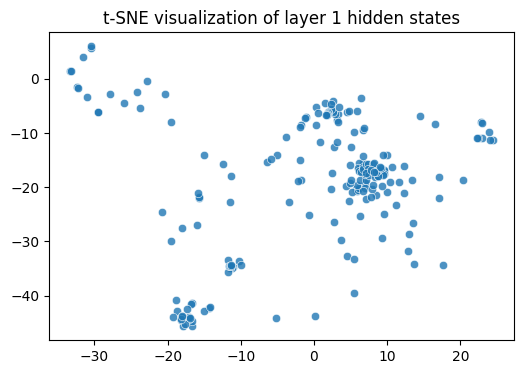

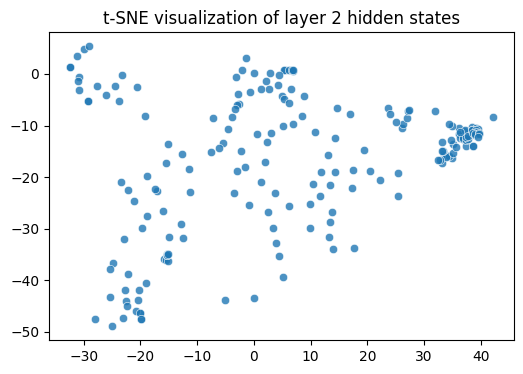

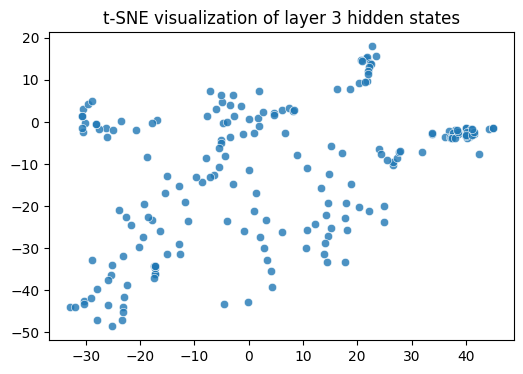

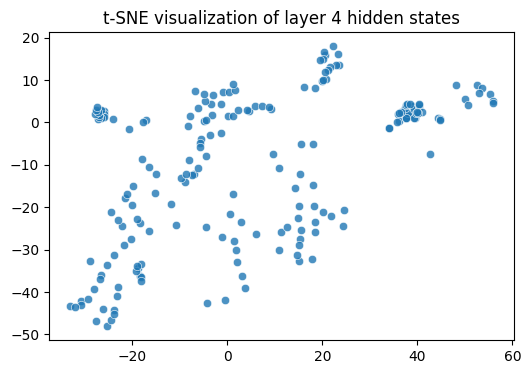

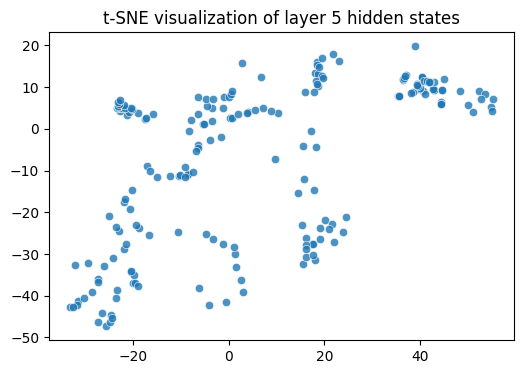

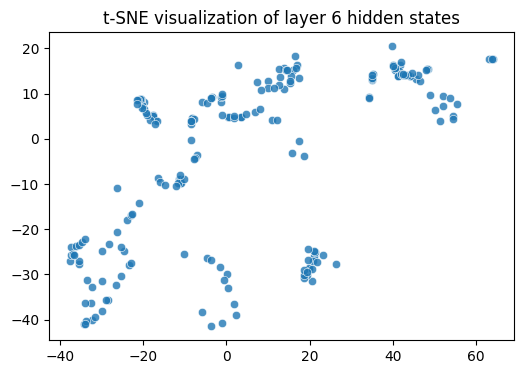

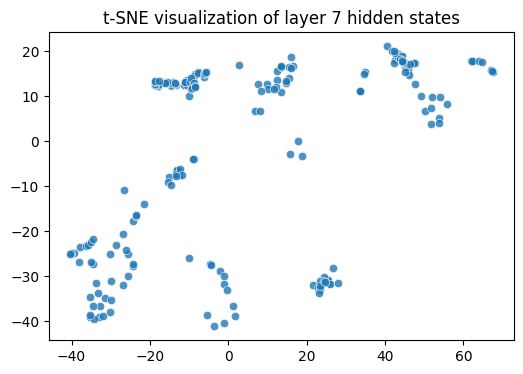

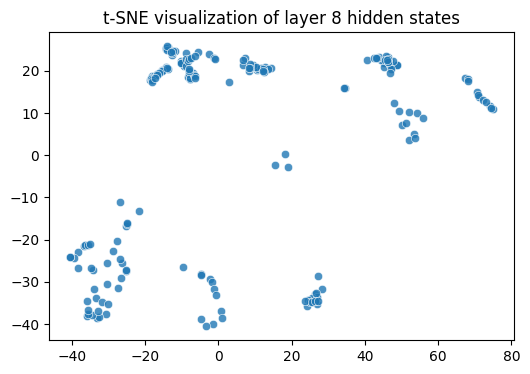

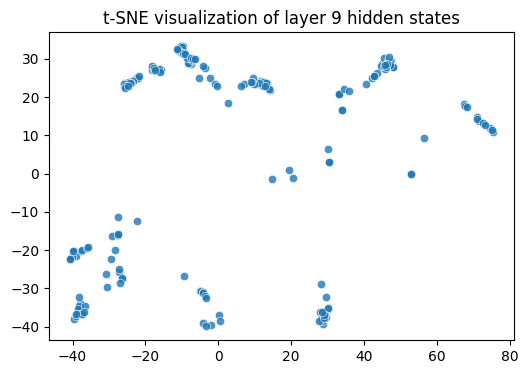

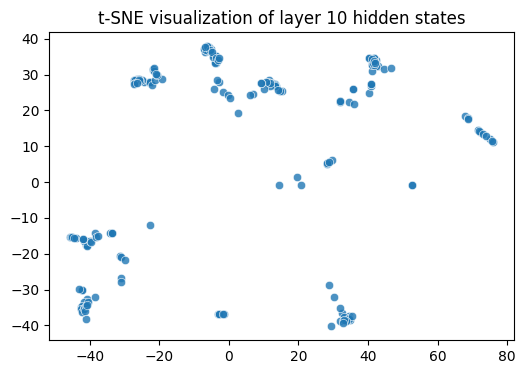

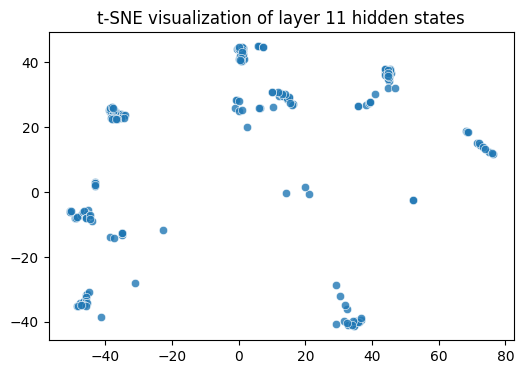

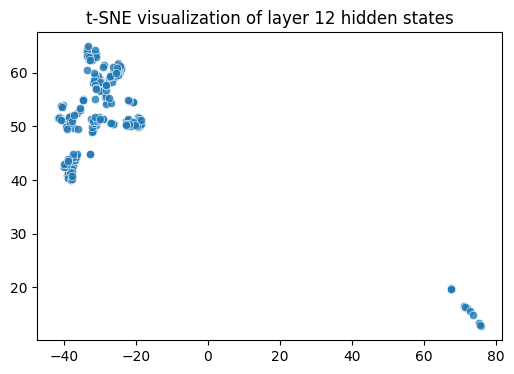

In [ ]:
# For each layer visualize the hidden states

for i, layer_hidden_states in enumerate(hidden_states_vis):
  start_idx = i * num_patches_per_layer
  end_idx = start_idx + num_patches_per_layer
  tsne_layer_embeddings = tsne_embeddings[start_idx:end_idx, :]

  plt.figure(figsize=(6, 4))
  sns.scatterplot(
      x=tsne_layer_embeddings[:, 0],
      y=tsne_layer_embeddings[:, 1],
      palette="viridis",
      legend=False,
      alpha=0.8
  )

  plt.title(f't-SNE visualization of layer {i+1} hidden states')
  plt.show()

In [ ]:
# Interactive visualization

layer_indices = np.repeat(np.arange(len(hidden_states_vis)), [hs.shape[0] for hs in hidden_states_vis])
patch_indices = np.concatenate([np.arange(hs.shape[0]) for hs in hidden_states_vis])

palette = sns.color_palette("tab20", n_colors=len(hidden_states_vis)).as_hex()
fig = go.Figure()
for i, color in enumerate(palette):
  layer_mask = layer_indices == i # filter indices for the current layer
  layer_tsne_embeddings = tsne_embeddings[layer_mask]

  fig.add_trace(go.Scattergl(
      x=layer_tsne_embeddings[:, 0],
      y=layer_tsne_embeddings[:, 1],
      mode='markers',
      marker=dict(size=7, color=color),
      name=f'Layer {i + 1}',
      text=[f'Layer {i + 1}, Patch {p}' for p in patch_indices[layer_mask]],
      hoverinfo='text'
  ))

fig.update_layout(
    title={
        'text': 't-SNE visualization of hidden states across layers',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    hovermode='closest',
    legend_title_text='Layer'
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show(renderer="colab")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


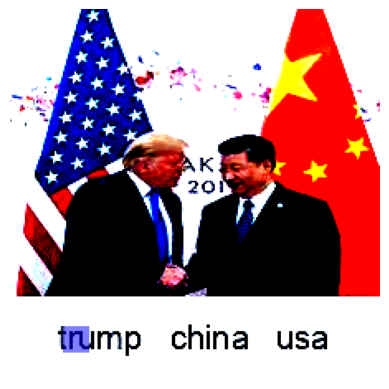

In [ ]:
# Show the patch in image

plot_patch(170, patch_size=patch_size, input_image=image) # -> see layer 11 and 12, patches 169, 170, 76, 89 (trump) and patches 40, 176 (china)

### **Other ViT models**

In [ ]:
# ViT available models (see also: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py)

all_vit_models = timm.list_models('*vit*', pretrained=True)
all_vit_models

['convit_base.fb_in1k',
 'convit_small.fb_in1k',
 'convit_tiny.fb_in1k',
 'crossvit_9_240.in1k',
 'crossvit_9_dagger_240.in1k',
 'crossvit_15_240.in1k',
 'crossvit_15_dagger_240.in1k',
 'crossvit_15_dagger_408.in1k',
 'crossvit_18_240.in1k',
 'crossvit_18_dagger_240.in1k',
 'crossvit_18_dagger_408.in1k',
 'crossvit_base_240.in1k',
 'crossvit_small_240.in1k',
 'crossvit_tiny_240.in1k',
 'davit_base.msft_in1k',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_in1k',
 'efficientvit_b2.r256_in1k',
 'efficientvit_b2.r288_in1k',
 'efficientvit_b3.r224_in1k',
 'efficientvit_b3.r256_in1k',
 'efficientvit_b3.r288_in1k',
 'efficientvit_l1.r224_in1k',
 'efficientvit_l2.r224_in1k',
 'efficientvit_l2.r256_in1k',
 'efficientvit_l2.r288_in1k',
 'efficientvit_l2.r384_in1k',
 'efficientvit_l3.r224_in1k',
 'efficientvit_l3.r256_in1k',
 'efficientvit_l3.r320_in1

In [66]:
# Load a ViT model (e.g., https://arxiv.org/pdf/2010.11929v2.pdf) -> we should experiment more and write down the results/insights

patch_size = 14 # patch size

# model = timm.create_model(f'vit_base_patch{patch_size}_224.orig_in21k', pretrained=True, exportable=True) # ViT original, imagenet21k
model = timm.create_model(f'vit_large_patch14_clip_quickgelu_224.openai', pretrained=True, exportable=True) # ours as above
# model = timm.create_model(f'vit_huge_patch{patch_size}_clip_224.laion2b', pretrained=True, exportable=True) # laion
# model = timm.create_model(f'vit_large_patch{patch_size}_clip_quickgelu_224.metaclip_2pt5b', pretrained=True, exportable=True) # MetaCLIP
# model = timm.create_model(f'vit_huge_patch14_clip_quickgelu_224.dfn5b', pretrained=True, exportable=True) # DFN dataset

model.eval()
num_layers = model.depth # number of layers
# num_layers = 12
nodes, _ = get_graph_node_names(model, tracer_kwargs={'leaf_modules': [PatchEmbed]}) # intermediate transformations
pprint(nodes)
print(model.default_cfg)

['x',
 'patch_embed',
 'pos_embed',
 'cls_token',
 'getattr',
 'getitem',
 'expand',
 'cat',
 'add',
 'pos_drop',
 'patch_drop',
 'norm_pre',
 'blocks.0.norm1',
 'blocks.0.attn.getattr',
 'blocks.0.attn.getitem',
 'blocks.0.attn.getitem_1',
 'blocks.0.attn.getitem_2',
 'blocks.0.attn.qkv',
 'blocks.0.attn.reshape',
 'blocks.0.attn.permute',
 'blocks.0.attn.unbind',
 'blocks.0.attn.getitem_3',
 'blocks.0.attn.getitem_4',
 'blocks.0.attn.getitem_5',
 'blocks.0.attn.q_norm',
 'blocks.0.attn.k_norm',
 'blocks.0.attn.mul',
 'blocks.0.attn.transpose',
 'blocks.0.attn.matmul',
 'blocks.0.attn.softmax',
 'blocks.0.attn.attn_drop',
 'blocks.0.attn.matmul_1',
 'blocks.0.attn.transpose_1',
 'blocks.0.attn.reshape_1',
 'blocks.0.attn.proj',
 'blocks.0.attn.proj_drop',
 'blocks.0.ls1',
 'blocks.0.drop_path1',
 'blocks.0.add',
 'blocks.0.norm2',
 'blocks.0.mlp.fc1',
 'blocks.0.mlp.act.mul',
 'blocks.0.mlp.act.sigmoid',
 'blocks.0.mlp.act.mul_1',
 'blocks.0.mlp.drop1',
 'blocks.0.mlp.norm',
 'blocks.

In [67]:
# Access attention weights and hidden states

image = Image.open(data_path + "stop_sign_labels_captioned.jpg") # image to interpret
# text = "london  usa  paris  すし  japan" # rastered text
# image = text_to_image(text, font_size=15, image_size=(224, 224), vertical_offset=5, font_path=data_path + "NotoSansJP-Regular.ttf")

transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model)) # preprocessing
image = transform(image).unsqueeze(0)

attention_weights = ()
hidden_states = ()

for layer in range(num_layers):
  feature_extractor_attn = create_feature_extractor( # attention (post-softmax)
      model, return_nodes=[f'blocks.{layer}.attn.softmax'],
      tracer_kwargs={'leaf_modules': [PatchEmbed]})
  feature_extractor_hs = create_feature_extractor( # hidden states
      model, return_nodes=[f'blocks.{layer}.add_1'],
      tracer_kwargs={'leaf_modules': [PatchEmbed]})

  with torch.no_grad():
    attention = feature_extractor_attn(image)[f'blocks.{layer}.attn.softmax']
    hidden_state = feature_extractor_hs(image)[f'blocks.{layer}.add_1']

  attention_weights = attention_weights + (attention,)
  hidden_states = hidden_states + (hidden_state,)

image, attention_weights, hidden_states = image.squeeze(0).cpu().numpy(), tuple(tensor.cpu().numpy() for tensor in attention_weights), tuple(tensor.cpu().numpy() for tensor in hidden_states)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

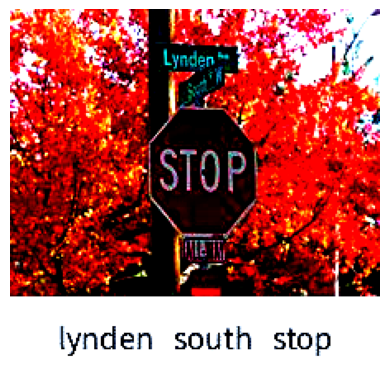

In [68]:
# Show the image we want to interpret

plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


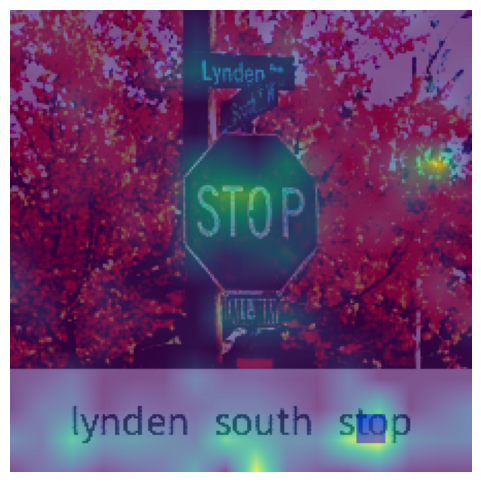

In [98]:
# Show the attendance (attention weights) between patches

plot_attention_map(attention_weights, image, patch_size=patch_size, patch=236, layer=24, head=None, attn_map=False, log=False)

In [ ]:
# Visualize hidden states (t-SNE)

# Concatenate all hidden states across all layers
num_patches_per_layer = int((224 / patch_size)**2)
hidden_states_vis = [hidden_state.squeeze(0)[1:] for hidden_state in hidden_states[:num_layers]]
all_hidden_states = np.concatenate(hidden_states_vis, axis=0)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_hidden_states)

# Interactive visualization
layer_indices = np.repeat(np.arange(len(hidden_states_vis)), [hs.shape[0] for hs in hidden_states_vis])
patch_indices = np.concatenate([np.arange(hs.shape[0]) for hs in hidden_states_vis])

palette = sns.color_palette("tab20c", n_colors=len(hidden_states_vis)).as_hex()
fig = go.Figure()
for i, color in enumerate(palette):
  layer_mask = layer_indices == i # filter indices for the current layer
  layer_tsne_embeddings = tsne_embeddings[layer_mask]

  fig.add_trace(go.Scattergl(
      x=layer_tsne_embeddings[:, 0],
      y=layer_tsne_embeddings[:, 1],
      mode='markers',
      marker=dict(size=7, color=color),
      name=f'Layer {i + 1}',
      text=[f'Layer {i + 1}, Patch {p}' for p in patch_indices[layer_mask]],
      hoverinfo='text'
  ))

fig.update_layout(
    title={
        'text': 't-SNE visualization of hidden states across layers',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    hovermode='closest',
    legend_title_text='Layer'
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show(renderer="colab")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


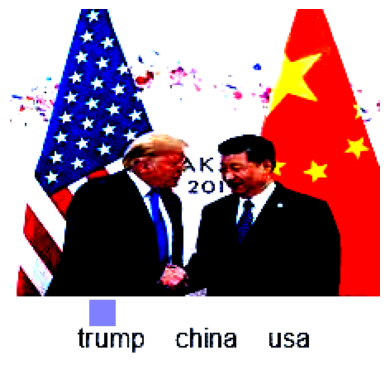

In [ ]:
# Show the patch in image

plot_patch(157, patch_size=patch_size, input_image=image)

### **"True" multimodal models**

**We will probably delve into this in a future extended work.**

#### **ViLBERT**

In [ ]:
# Load a multimodal model (e.g., ViLBERT, see also the models.yaml file)

# model_cls = registry.get_model_class("vilbert")
# model = model_cls.from_pretrained("vilbert.pretrained.cc.original")
model = ViLBERT.from_pretrained("vilbert.pretrained.cc.original").to(device)
model.eval()

Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bert_model_name": "bert-base-uncased",
  "bi_attention_type": 1,
  "bi_hidden_size": 1024,
  "bi_intermediate_size": 1024,
  "bi_num_attention_heads": 8,
  "bypass_transformer": false,
  "classifier_dropout": null,
  "cut_first": "text",
  "dynamic_attention": false,
  "embedding_strategy": "plain",
  "fast_mode": false,
  "finetune_lr_multiplier": 1,
  "fixed_t_layer": 0,
  "fixed_v_layer": 0,
  "freeze_base": false,
  "fusion_method": "mul",
  "hard_cap_seq_len": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "in_batch_pairs": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model": "bert",
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_negative": 128,
  "objective": 0,
  "pad_token_id": 0,
  "pooling_method": "mul",
  "position_embedding_type": "absolute",
  "ra

ViLBERT(
  (model): ViLBERTForPretraining(
    (bert): ViLBERTBase(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (v_embeddings): BertImageFeatureEmbeddings(
        (image_embeddings): Linear(in_features=2048, out_features=1024, bias=True)
        (image_location_embeddings): Linear(in_features=5, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bi

In [ ]:
# Here we try to do perform a forward pass in the ViLBERT model (needs caution for different datasets and preprocessors)
# See also: https://github.com/facebookresearch/mmf/blob/notebooks/notebooks/kdd_tutorial.ipynb

# We will write the code shortly... (if time permits) -> probably in a future extended work

config = load_yaml(data_path + "models/vilbert.pretrained.cc.original/config.yaml")
processors = build_processors(config.dataset_config.masked_conceptual_captions.processors) # build processors based on the model, dataset config

def create_sample(image_path, text, processors, device="cuda"):
  """Create a sample list for input to the ViLBERT model."""
  image = Image.open(image_path).convert("RGB") # image
  if "image_processor" in processors:
    image_processing_result = processors["image_processor"](image)
    image_tensor = image_processing_result["image_feature_0"].float().to(device)
    image_location = image_processing_result["image_location"].float().to(device)
  else:
    # handle case where specific image processing is not defined
    # image_tensor = torch.zeros(1, 3, 224, 224).to(device) # adjust size as per model requirement
    transform_to_tensor = transforms.ToTensor()
    image_tensor = transform_to_tensor(image).unsqueeze(0)
    upsample = torch.nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
    image_tensor = upsample(image_tensor).to(device)
    # image_location = torch.zeros(1, 4).to(device)  # placeholder

  processed_text = processors["masked_token_processor"]({"text_a": text}) # text
  # input_ids = processed_text["input_ids"].unsqueeze(0).to(device)
  # attention_mask = processed_text["attention_mask"].unsqueeze(0).to(device)
  # token_type_ids = processed_text.get("token_type_ids", torch.zeros_like(input_ids)).to(device)

  sample = {
    "image_feature_0": image_tensor.unsqueeze(0),
    # "image_location": image_location,
    **processed_text
  }
  current_sample = Sample(sample)
  current_sample.dataset_name = "default_dataset"
  sample_list = SampleList([current_sample])

  return sample_list.to(device)

# Example usage
image_path = data_path + "usa_china_captioned.jpg"
text = "usa, china, donald trump"

sample_list = create_sample(image_path, text, processors, device)
with torch.no_grad():
  output = model(sample_list)

#### **MuLaP**

In [ ]:
# We will write the code in the future...